In [212]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sklearn.preprocessing
import sklearn.neural_network

In [213]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import h5py
warnings.resetwarnings()
warnings.simplefilter(action='ignore', category=ImportWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=ResourceWarning)

In [214]:
import theano
import theano.tensor as T

In [215]:
def sgd(cost, params, lr=0.001, epsilon=1e-6):
    grads = T.grad(cost=cost, wrt=params)
    updates = []
    for p, g in zip(params, grads):
        updates.append((p, p - lr * g))
    return updates

In [216]:
def sgd_momentum(cost, params, lr=0.001, beta=0.9,epsilon=1e-6):  #no bias correction
    grads = T.grad(cost=cost, wrt=params)
    updates = []
    for p, g in zip(params, grads):
        v= theano.shared(p.get_value() * 0.)
        vc= beta*v + (1-beta)*g
        updates.append((v,vc))
        updates.append((p, p - lr * vc))
    return updates

In [217]:
def adagrad(cost, params, lr=0.001, epsilon=1e-6):
    grads = T.grad(cost=cost, wrt=params)
    updates = []
    for p, g in zip(params, grads):
        acc = theano.shared(p.get_value() * 0.)
        acc_new = acc + g ** 2
        gradient_scaling = T.sqrt(acc_new + epsilon)
        g = g / gradient_scaling
        updates.append((acc, acc_new))
        updates.append((p, p - lr * g))
    return updates

In [218]:
def adam(cost, params, lr=0.001, beta=0.9, epsilon=1e-6):  #no bias correction, T.sqrt if **0.5 not work
    grads = T.grad(cost=cost, wrt=params)
    updates = []
    for p, g in zip(params, grads):
        m=theano.shared(p.get_value()* 0.)
        v=theano.shared(p.get_value()* 0.)
        mc = beta*m + (1-beta)*g
        vc = beta*v + (1-beta)*g**2
        updates.append((m,mc))
        updates.append((v,vc))
        updates.append((p, p - lr * mc/(epsilon+vc**0.5)))
    return updates

In [219]:
def RMSprop(cost, params, lr=0.001, beta=0.9,epsilon=1e-6):
    grads = T.grad(cost=cost, wrt=params)
    updates = []
    for p, g in zip(params, grads):
        v= theano.shared(p.get_value() * 0.)
        vc = beta*v + (1-beta)*g**2
        updates.append((v,vc))
        updates.append((p, p - lr * g/(epsilon+vc**(0.5))))
    return updates

In [220]:
import pickle, gzip
f = gzip.open('mnist.pkl.gz','rb')
train_set, valid_set, test_set = pickle.load(f,encoding='latin-1')
f.close()

In [221]:
train_set[0][train_set[0]>=0.5]=1
train_set[0][train_set[0]<0.5]=0

In [222]:
valid_set[0][valid_set[0]>=0.5]=1
valid_set[0][valid_set[0]<0.5]=0

In [223]:
test_set[0][test_set[0]>=0.5]=1
test_set[0][test_set[0]<0.5]=0

In [224]:
x_train=theano.function([], T.concatenate([train_set[0], valid_set[0]]))()

In [225]:
x_test = theano.function([], theano.shared(test_set[0]))()

In [226]:
n_hidden = 100 # the size of hidden layers in MLP
n_latent = 2 # the dimension of z
n_input = x_train.shape[1] # the dimension of x's feature space
batch_size = 100
n_epochs = 10000

In [227]:
def init_w(shape):
    x = np.random.randn(*shape)
    float_x = np.asarray(x * 0.01, dtype=theano.config.floatX)
    return theano.shared(float_x)

In [228]:
# Parameters
# Gaussian MLP weights and biases (encoder)
#initialize \phi 

b3 = init_w((n_hidden, ))
b2 = init_w((n_latent, ))
b1 = init_w((n_latent, ))


W3 = init_w((n_input, n_hidden))
W2 = init_w((n_hidden, n_latent))
W1 = init_w((n_hidden, n_latent))


In [229]:
# Gaussian Encoder
x = T.matrix("x")
h_encoder = T.tanh(T.dot(x, W3) + b3)
mu = T.dot(h_encoder, W1) + b1
log_sig2 = T.dot(h_encoder, W2) + b2
# This expression is simple (not an expectation) because we're using normal priors and posteriors
DKL = (1.0 + log_sig2 - mu**2 - T.exp(log_sig2)).sum(axis = 1)/2.0

In [230]:
# Bernoulli MLP weights and biases (decoder)
bernoulli_b1 = init_w((n_hidden, ))
bernoulli_b2 = init_w((n_input, ))

bernoulli_W1 = init_w((n_latent, n_hidden))
bernoulli_W2 = init_w((n_hidden, n_input))

In [231]:
# Bernoulli Decoder
std_normal = T.matrix("std_normal") 
z = mu + T.sqrt(T.exp(log_sig2))*std_normal
h_decoder = T.tanh(T.dot(z, bernoulli_W1) + bernoulli_b1)
y = T.nnet.sigmoid(T.dot(h_decoder, bernoulli_W2) + bernoulli_b2)
log_likelihood = -T.nnet.binary_crossentropy(y, x).sum(axis = 1)


In [232]:
# Only the weight matrices W will be regularized (weight decay)
W = [W3, W1, W2, bernoulli_W1, bernoulli_W2]
b = [b3, b1, b2, bernoulli_b1, bernoulli_b2]
params = W + b

In [233]:
# Our lb and cost
lower_bound = (DKL + log_likelihood).mean()
cost = -lower_bound

In [234]:
updates = RMSprop(cost, params, lr=0.02)

In [235]:
train_model = theano.function(inputs=[x, std_normal], 
                              outputs=cost, 
                              updates=updates,
                              mode='FAST_RUN',
                              allow_input_downcast=True)
                              

In [236]:
%%time

training_RMSprop = []
#validation = []
for i in range(n_epochs):
    minibatch_train = [ x_train[j] for j in np.random.randint(0,x_train.shape[0],batch_size) ]

    #val_cost = eval_model(x_test, np.random.normal(size = (len(x_test), n_latent)))
    train_cost = train_model(minibatch_train, np.random.normal(size = (batch_size, n_latent)))
    
    training_RMSprop.append(train_cost)
    #validation.append(val_cost)    

CPU times: user 6min 50s, sys: 11min 11s, total: 18min 1s
Wall time: 2min 16s


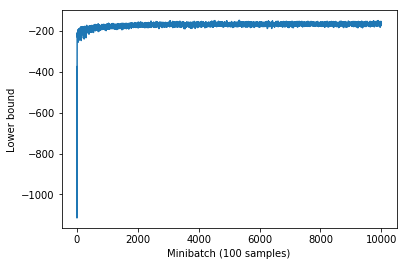

In [237]:
plt.ylabel("Lower bound")
plt.xlabel("Minibatch (" + str(batch_size) + " samples)")
plt.plot(-np.array(training_RMSprop))
plt.show()

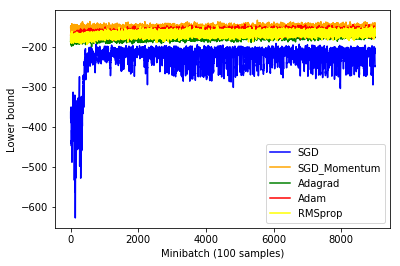

In [241]:
plt.ylabel("Lower bound")
plt.xlabel("Minibatch (" + str(batch_size) + " samples)")
plt.plot(-np.array(training_sgd[1000:]),'blue',label='SGD')
plt.plot(-np.array(training_sgd_momentum[1000:]),'orange',label='SGD_Momentum')
plt.plot(-np.array(training_adagrad[1000:]),'green',label='Adagrad')
plt.plot(-np.array(training_adam[1000:]),'red',label='Adam')
plt.plot(-np.array(training_RMSprop[1000:]),'yellow',label='RMSprop')
plt.legend(loc='lower right', bbox_to_anchor=(1, 0))
plt.show()

In [122]:
updates = adagrad(cost, params, lr=0.02)

In [123]:
train_model_likelihood = theano.function(inputs=[x, std_normal], 
                              outputs=log_likelihood.mean(), 
                              updates=updates,
                              mode='FAST_RUN',
                              allow_input_downcast=True)

In [124]:
training_likelihood = []
#validation = []
for i in range(n_epochs):
    minibatch_train = [ x_train[j] for j in np.random.randint(0,x_train.shape[0],batch_size) ]

    #val_cost = eval_model(x_test, np.random.normal(size = (len(x_test), n_latent)))
    likelihood = train_model_likelihood(minibatch_train, np.random.normal(size = (batch_size, n_latent)))
    
    training_likelihood.append(likelihood)
    #validation.append(val_cost)    

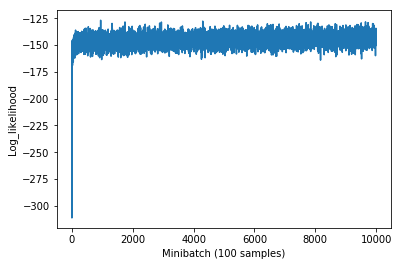

In [127]:
plt.ylabel("Log_likelihood")
plt.xlabel("Minibatch (" + str(batch_size) + " samples)")
plt.plot(training_likelihood)

In [ ]:
'''gaussian decoder and freyface starts next:'''

In [10]:
from scipy.io import loadmat
ff = loadmat('frey_rawface.mat', squeeze_me=True, struct_as_record=False)
ff1 = ff["ff"].T

In [52]:
f_train=ff1[:1500,]
f_test=ff1[1501:,]

In [12]:
n_hidden = 100 # the size of hidden layers in MLP
n_latent = 2 # the dimension of z
n_input = f_train.shape[1] # the dimension of f's feature space
batch_size = 100
n_epochs = 100000

In [13]:
def init_w(shape):
    x = np.random.randn(*shape)
    float_x = np.asarray(x * 0.01, dtype=theano.config.floatX)
    return theano.shared(float_x)

In [14]:
# Parameters
# Gaussian MLP weights and biases (encoder)
#initialize \phi 

b3 = init_w((n_hidden, ))
b2 = init_w((n_latent, ))
b1 = init_w((n_latent, ))


W3 = init_w((n_input, n_hidden))
W2 = init_w((n_hidden, n_latent))
W1 = init_w((n_hidden, n_latent))

In [15]:
#Gaussian encoder
x = T.matrix("x")
h_encoder = T.tanh(T.dot(x, W3) + b3)
mu = T.dot(h_encoder, W1) + b1
log_sig2 = T.dot(h_encoder, W2) + b2
# This expression is simple (not an expectation) because we're using normal priors and posteriors
DKL = (1.0 + log_sig2 - mu**2 - T.exp(log_sig2)).sum(axis = 1)/2.0

In [16]:
# Parameters
# Gaussian MLP weights and biases (decoder)
#initialize \theta

b6 = init_w((n_hidden, ))
b5 = init_w((n_input, ))
b4 = init_w((n_input, ))


W6 = init_w((n_latent, n_hidden))
W5 = init_w((n_hidden, n_input))
W4 = init_w((n_hidden, n_input))

In [17]:
# Gaussian Decoder               --- ours!!!
std_normal = T.matrix("std_normal") 
z = mu + T.sqrt(T.exp(log_sig2))*std_normal
h_decoder = T.tanh(T.dot(z, W6) + b6)
mu_prime = T.dot(h_decoder, W4) + b4
log_sig2_prime = T.dot(h_decoder, W5) + b5

#log_likelihood_gaus=-0.5*(x.shape[1]*np.log(2*np.pi))-0.5*(x-mu_prime)**2/(np.exp(log_sig2_prime)).sum(axis=0)
#log_likelihood_gaus=-0.5*(x.shape[1]*np.log(2*np.pi))-0.5*sum(log_sig2_prime)-0.5*(x-mu_prime)**2/(np.exp(log_sig2_prime)).sum(axis=1)
#log_likelihood_gaus=(-0.5*(x.shape[1]*np.log(2*np.pi)))+(-0.5*(log_sig2_prime.sum(axis=0)))+((-0.5*(x-mu_prime)**2/(np.exp(log_sig2_prime))).sum(axis=0))


In [18]:
log_likelihood_gaus= (-(0.5 * np.log(2 * np.pi) + 0.5 * log_sig2_prime) - 0.5 * ((x - mu_prime)**2 / T.exp(log_sig2_prime))).sum(axis=1).mean(axis=0)

In [19]:
# Only the weight matrices W will be regularized (weight decay)
W = [W3, W1, W2, W6, W4, W5]
b = [b3, b1, b2, b6, b5, b4]
params = W + b

In [20]:
# Our lb and cost
lower_bound = (DKL + log_likelihood_gaus).mean()
#lower_bound=DKL.mean()
cost = -lower_bound

In [21]:
def adagrad(cost, params, lr=0.001, epsilon=1e-6):
    grads = T.grad(cost=cost, wrt=params)
    updates = []
    for p, g in zip(params, grads):
        acc = theano.shared(p.get_value() * 0.)
        acc_new = acc + g ** 2
        gradient_scaling = T.sqrt(acc_new + epsilon)
        g = g / gradient_scaling
        updates.append((acc, acc_new))
        updates.append((p, p - lr * g))
    return updates

In [22]:
updates = adagrad(cost, params, lr=0.02)

In [23]:
train_model = theano.function(inputs=[x, std_normal], 
                              outputs=cost, 
                              updates=updates,
                              mode='FAST_RUN',
                              allow_input_downcast=True)
                              
eval_model = theano.function(inputs=[x, std_normal], outputs=lower_bound,
                             mode='FAST_RUN',
                             allow_input_downcast=True) 

In [34]:
np.random.seed(1)
training = []
#validation = []
for i in range(n_epochs):
    minibatch_train = [ f_train[j] for j in np.random.randint(0,f_train.shape[0],batch_size) ]

    #val_cost = eval_model(x_test, np.random.normal(size = (len(x_test), n_latent)))
    train_cost = train_model(minibatch_train, np.random.normal(size = (batch_size, n_latent)))
    
    training.append(train_cost)
    #validation.append(val_cost)    

In [35]:
lb=[-i for i in training]

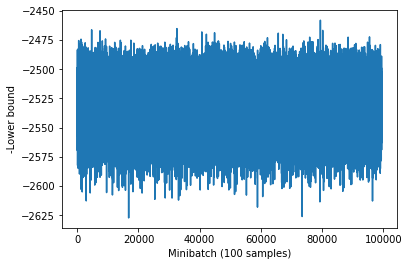

In [38]:
plt.ylabel("-Lower bound")
plt.xlabel("Minibatch (" + str(batch_size) + " samples)")
plt.plot(lb[500:],)

In [27]:
updates = adagrad(cost, params, lr=0.02)

In [28]:
train_model_likelihood = theano.function(inputs=[x, std_normal], 
                              outputs=log_likelihood_gaus, 
                              updates=updates,
                              mode='FAST_RUN',
                              allow_input_downcast=True)

In [29]:
training_likelihood = []
#validation = []
for i in range(n_epochs):
    minibatch_train = [ f_train[j] for j in np.random.randint(0,f_train.shape[0],batch_size) ]

    #val_cost = eval_model(x_test, np.random.normal(size = (len(x_test), n_latent)))
    likelihood = train_model_likelihood(minibatch_train, np.random.normal(size = (batch_size, n_latent)))
    
    training_likelihood.append(likelihood)
    #validation.append(val_cost)    

In [30]:
training_likelihood[5000]

array(-2526.64434441)

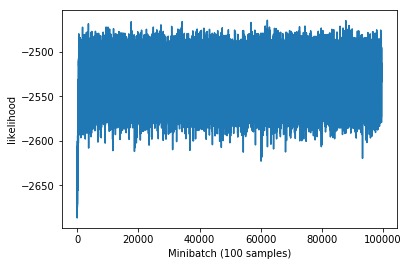

In [39]:
plt.ylabel("likelihood")
plt.xlabel("Minibatch (" + str(batch_size) + " samples)")
plt.plot(training_likelihood[500:])

In [40]:
# Extract estimated parameters (W, b)
est_W3 = updates[1][0].get_value()
est_W1 = updates[3][0].get_value()
est_W2 = updates[5][0].get_value()
est_W6 = updates[7][0].get_value()
est_W4 = updates[9][0].get_value()
est_W5 = updates[11][0].get_value()

est_b3 = updates[13][0].get_value()
est_b1 = updates[15][0].get_value()
est_b2 = updates[17][0].get_value()
est_b6 = updates[19][0].get_value()
est_b4 = updates[21][0].get_value()
est_b5 = updates[23][0].get_value()

In [41]:
est_h_encoder = np.tanh(np.dot(f_test, est_W3) + est_b3)
phi_mu = np.dot(est_h_encoder, est_W1) + est_b1
phi_log_sig2 = np.dot(est_h_encoder, est_W2) + est_b2

In [42]:
z_test = phi_mu + np.sqrt(np.exp(phi_log_sig2))*np.random.randn(phi_log_sig2.shape[0], phi_log_sig2.shape[1])

In [43]:
est_h_decoder=np.tanh(np.dot(z_test,est_W6)+ est_b6)
theta_mu = np.dot(est_h_decoder,est_W4) + est_b4
theta_log_sig2=np.dot(est_h_decoder, est_W5) + est_b5

In [45]:
theta_log_sig2.shape

(464, 560)

In [46]:
f_new=np.random.normal(theta_mu,theta_log_sig2,[theta_mu.shape[0],theta_mu.shape[1]])

In [47]:
f_new.shape

(464, 560)

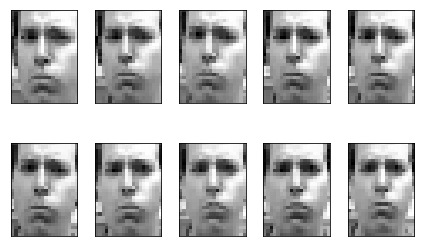

In [57]:
f_test1 = f_test.reshape([464, 28, 20])
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(f_test1[i], cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()

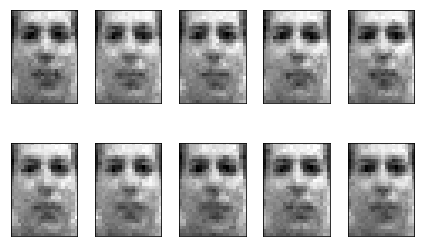

In [58]:
f_new1 = f_new.reshape([464, 28, 20])
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(f_new1[i], cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()